In [1]:
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter , lfilter , find_peaks, peak_widths
from scipy.fftpack import fft, fftfreq
%matplotlib inline

from scipy import signal

In [2]:
'''  MODEL PARAMETERS '''

Cm = 100*pF                    # membrane capacitance
g_leak =10*nS                  # leak conductance
E_rest = -65*mvolt             # membrane rest potential
V_thresh = -52*mvolt           # membrane threshold potential
V_reset = -67*mvolt            # membrane reset potential 
tau_m = 10*ms                  # membrane time constant
tau_r = 1*ms                   # absolute refractory period

E_i  = -75*mvolt               # inhib. reversal potential
E_e  =  0*mvolt                # excit. reversal potential

tau_l = 1*ms                   # time delay 
tau_r_e  = 0.5*ms
tau_d_e  = 2*ms
tau_r_i  = 0.45*ms
tau_d_i  = 1.2*ms

g_peak_e = 1*nS
g_peak_i = 5*nS


N_inhib = 200      # number of inhibitory inter neurons in the network
N_excit = 800      # each inter neuron gets input from 800 excit. neurons.

In [3]:
def heaviside(t , t0):
    if t >= t0:
        return 1
    else:
        return 0  

# Check timecourse of conductance for a single neuron

In [4]:
defaultclock.dt = 0.01*ms             # choose a particular time step
timestep = 0.01*ms
input_rate = (5000/N_excit)*Hz       # total input to each neuron is 5 KHz


''' ----------  NEURON EQUATIONS ------------- '''
'''
T_e = (tau_r_e*tau_d_e)*log(tau_r_e/tau_d_e)/(tau_r_e - tau_d_e)
T_i = (tau_r_i*tau_d_i)*log(tau_r_i/tau_d_i)/(tau_r_i - tau_d_i)

max_e  = exp(-T_e/tau_d_e) - exp(-T_e/tau_r_e)
max_i  = exp(-T_i/tau_d_i) - exp(-T_i/tau_r_i)
'''

max_e = ( (tau_d_e/tau_r_e)**(tau_r_e/(tau_r_e-tau_d_e)) - (tau_d_e/tau_r_e)**(tau_d_e/(tau_r_e-tau_d_e))    ) 
max_i = ( (tau_d_i/tau_r_i)**(tau_r_i/(tau_r_i-tau_d_i)) - (tau_d_i/tau_r_i)**(tau_d_i/(tau_r_i-tau_d_i))    ) 


J_e = ((tau_d_e-tau_r_e)/tau_r_e)*(g_peak_e/nS)/max_e
J_i = ((tau_d_e-tau_r_e)/tau_r_e)*(g_peak_i/nS)/max_i

eqs_model = ''' 
dv/dt      = (g_leak*(E_rest - v) + I_syn )/Cm : volt (unless refractory)
I_syn      = I_ampa_exc + I_rec            : amp
I_ampa_exc = g_peak_e*(E_e - v)*g_e/max_e  : amp 
I_rec      = g_peak_i*(E_i - v)*g_i/max_i  : amp
dg_e/dt    = (-g_e + x_e)/tau_d_e : 1 
dx_e/dt    = -x_e/tau_r_e  : 1
dg_i/dt    = (-g_i + x_i)/tau_d_i : 1 
dx_i/dt    = -x_i/tau_r_i  : 1
'''
ampa_pre = '''
x_e += J_e
'''
rec_pre = '''
x_i += J_i
'''

times  = np.arange(50, 200, 30)*ms
indices = np.repeat(0,len(times))

SGG = SpikeGeneratorGroup(1 , indices, times)
G = NeuronGroup(N_inhib, eqs_model, threshold='v> V_thresh', reset='v = V_reset', refractory = tau_r,  method ='euler')

# Excitatory Synapse Group
S_excit = Synapses(SGG , G ,  on_pre= ampa_pre , delay = tau_l , method = 'euler')
S_excit.connect(i = 0, j = 10)

# Inhibitory, Recurrent Synapse Group

S_inhib = Synapses(G,G, on_pre= rec_pre , delay = tau_l , method = 'euler')
S_inhib.connect(condition='i!=j', p=0.2)

# Spike, State Monitors

State_Mon = StateMonitor(G, variables = ['v', 'g_e' ] , record = True)
#Spike_Mon = SpikeMonitor(G)
#Rate_Mon = PopulationRateMonitor(G)

# initialise at rest 
G.v = E_rest
print('Before v = %s' % G.v[0])
run(200*ms)
print('After v = %s' % G.v[0])

WARNING    c:\users\debap\appdata\local\programs\python\python37\lib\site-packages\Cython\Compiler\Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\debap\.cython\brian_extensions\_cython_magic_977491d6de0534ef6a3a4584a6640019.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
 [py.warnings]
WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


Before v = -65. mV


WARNING    The name "timestep" refers to different objects in different namespaces used for resolving names in the context of group "neurongroup". Will use the object from the functions namespace with the value <Function>, but the name also refers to a variable in the run namespace with value 10. * usecond. [brian2.groups.group.Group.resolve.resolution_conflict]


After v = -65. mV


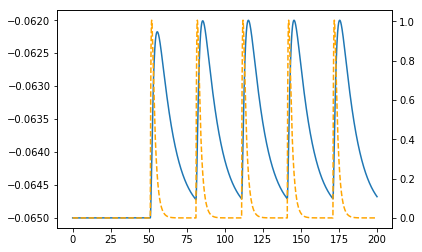

The peak synaptic conductance achievd is 1.0046614086937 
Timed spike inputs were given at [ 50.  80. 110. 140. 170.] ms


In [5]:
fig, ax = plt.subplots()
ax.plot(State_Mon.t/ms, State_Mon.v[10]/volt)

ax1 = ax.twinx()
ax1.plot(State_Mon.t/ms, State_Mon.g_e[10] , color = 'orange' , ls = '--')
ax1.set_ylabel('')
plt.show()

print('The peak synaptic conductance achievd is %s ' % np.max(State_Mon.g_e[10]))
print('Timed spike inputs were given at %s' % times)

# Actual simulations of the Network

In [6]:
def do_simulation(sim_dur, inp_freq, tau_d_i=1.2*ms, g_peak_i=5*nS):
    defaultclock.dt = 0.01*ms             # choose a particular time step
    timestep = 0.01*ms
    input_rate = (inp_freq/N_excit)*Hz       # total input to each neuron is 5 KHz
    

    ''' ----------  NEURON EQUATIONS ------------- '''

    
    

    max_e = ( (tau_d_e/tau_r_e)**(tau_r_e/(tau_r_e-tau_d_e)) - (tau_d_e/tau_r_e)**(tau_d_e/(tau_r_e-tau_d_e))    ) 
    max_i = ( (tau_d_i/tau_r_i)**(tau_r_i/(tau_r_i-tau_d_i)) - (tau_d_i/tau_r_i)**(tau_d_i/(tau_r_i-tau_d_i))    ) 


    J_e = ((tau_d_e-tau_r_e)/tau_r_e)*(g_peak_e/nS)/max_e
    J_i = ((tau_d_e-tau_r_e)/tau_r_e)*(g_peak_i/nS)/max_i
    
    
    eqs_model = ''' 
    dv/dt      = (g_leak*(E_rest - v) + I_syn )/Cm : volt (unless refractory)
    I_syn      = I_ampa_exc + I_rec            : amp
    I_ampa_exc = g_peak_e*(E_e - v)*g_e/max_e  : amp 
    I_rec      = g_peak_i*(E_i - v)*g_i/max_i  : amp
    dg_e/dt    = (-g_e + x_e)/tau_d_e : 1 
    dx_e/dt    = -x_e/tau_r_e  : 1
    dg_i/dt    = (-g_i + x_i)/tau_d_i : 1 
    dx_i/dt    = -x_i/tau_r_i  : 1
    '''
    ampa_pre = '''
    x_e += J_e
    '''
    rec_pre = '''
    x_i += J_i
    '''
    P = PoissonGroup(8400, rates=input_rate)

    G = NeuronGroup(N_inhib, eqs_model,threshold='v> V_thresh',reset='v=V_reset',refractory=tau_r,method ='euler')

    # Excitatory Synapse Group
    S_excit = Synapses(P,G, on_pre= ampa_pre , delay = tau_l , method = 'euler')
    S_excit.connect(p=0.095)
    
    # Inhibitory, Recurrent Synapse Group

    S_inhib = Synapses(G,G, on_pre= rec_pre , delay = tau_l , method = 'euler')
    S_inhib.connect(condition='i!=j', p=0.2)
    

    State_Mon = StateMonitor(G, 'v',record=True)
    Spike_Mon = SpikeMonitor(G)
    Rate_Mon = PopulationRateMonitor(G)

    # initialise at rest 
    G.v = E_rest
    print('Before v = %s' % G.v[0])
    run(sim_dur)
    print('After v = %s' % G.v[0])
    
    return (State_Mon, Spike_Mon, Rate_Mon)

In [7]:
def isi_analysis(spike_mon):
    # Inter-Spike-Interval (ISI)
    p = 0
    for j in range(200):
       
        spike_time_temp = spike_mon.t[np.where(spike_mon.i == j)[0]]/ms

        if len(spike_time_temp) > 1 & p==0:

            p = 1
            isi_array = np.diff(spike_time_temp)

            isi_means = np.mean(np.diff(spike_time_temp))
            isi_std = np.std(np.diff(spike_time_temp))
            isi_cv = isi_std/isi_means
        
        elif len(spike_time_temp) > 1 & p==1:

            isi_array = np.hstack((isi_array,np.diff(spike_time_temp)))

            isi_means = np.append(isi_means,np.mean(np.diff(spike_time_temp)))
            isi_std = np.append(isi_std,np.std(np.diff(spike_time_temp)))
            isi_cv = np.append(isi_cv,isi_std[-1]/isi_means[-1])
                  
    return isi_array , isi_means , isi_std, isi_cv

def cvar(isi_arr,inp_freq,gaba=0):
    cv_ind = np.std(isi_arr)/np.mean(isi_arr)
    cv_out = np.hstack((cv_ind,inp_freq,gaba,len(isi_arr)))

    return  cv_out

def q_factor(freq, sFFT):
    index = np.argmax(sFFT)
    results = peak_widths(sFFT, [index], rel_height=0.5)  # Calculates FWHM 
    rel_peak_amplitude = np.max(sFFT)/np.sum(sFFT)
    Q = rel_peak_amplitude/results[0]

    return Q , freq[index] 

def append_vals(Q_arr, F_peak , F_mean , Input_freq , q_val, f_peak_val, f_mean_val, input_freq_val,gaba):
    Q_arr[gaba]  += [q_val]
    F_peak[gaba] += [f_peak_val]
    F_mean[gaba] += [f_mean_val]
    Input_freq[gaba]   += [input_freq_val]
    
    
    return Q_arr, F_peak , F_mean , Input_freq
    

def plotISI(spike_mon,axI):
    isi_array , isi_means , isi_std  , cv  = isi_analysis(spike_mon)
    #axI.errorbar(np.arange(len(isi_means)) , np.sort(isi_means) , yerr = isi_std, label = 'f = 10kHz')
    axI.plot(np.sort(isi_means) , label = 'mean ISI')
    axI.plot(np.sort(isi_std) , label = 'stddev of ISI')
    #axI.set_xlabel('Neuron Index')
    axI.set_xticks([])
    axI.set_ylabel('ISI (ms)')
    #axI.set_title('ISI Variability No GABA' )
    axI.set_title('sorted (seperately) ISI-statistcs of the individual neurons')
    axI.legend()

def freq_analysis(time_vec, signal):
    
    # sampling freq.
    fs = 1000/(time_vec[1] - time_vec[0]) 

    # FFT & get power spectral density
    signalFFT = fft(signal-np.mean(signal))
    signalPSD = np.abs(signalFFT) ** 2
    # only up to fs/2, don't need mirror
    half = signalPSD[0:int(len(signalPSD)/2)]

    # create frequency-vector
    f = np.arange(0, fs/2, fs/(2*len(half)))

    return (f, half)
    #''''''''''
    #
    # Is the area under the FFT normalized???
    #
    #''''''''''
    
def mean_spike(Spike_Mon, sim_time):
    spike=np.zeros(200)
    for j in range(0,200): 
        spike[j]=sum((Spike_Mon.i==j)*1)/(sim_time)
    return spike

def FFTplot(freq, signalFFT, ax):
    
    ax.plot(freq,signalFFT,'orange',label='Spectral energy')
    ax.set_xlabel("$f$ [Hz]")
    ax.set_ylabel('Spectral energy')
    ax.legend(loc=7)
    ax.set_xlim([0, 500])
    ax.set_title("Histogram individual rate & spectral energy population")
    
def plot_time(t, s, ax):
    ax.plot(t, s)
    ax.set_xlabel('ms')
    ax.set_xlim((50,100))
    ax.set_ylabel('Spikes/s')
    ax.set_title('Network Population Activity')
    
def plot_firing_raster(Spike_Mon, ax):
    ax.plot(Spike_Mon.t/ms, Spike_Mon.i , '.k')
    ax.set_xlabel('ms')
    ax.set_xlim(50,100)
    ax.set_ylabel('Neuron Index')
    ax.set_title('Network Firing Raster Plot')

def plot_firing_dist(spike, ax):
    #ax.hist(Rate_Mon.rate/Hz , bins = 20)
    #ax.set_title('Firing Frequency Distribution')
    
    ax.hist(spike,bins=20,density=True,label='Neurons Spiking rate')
    ax.set_xlim(0,500)
    ax.set_xlabel("$f$ [Hz]")
    #ax.set_xlabel('Mean individual spike rate')
    ax.set_ylabel('Fraction of neurons')
    ax.legend()
    
def plot_time_and_freq(time, signal, axT, axF):
    # plot network activity in time domain
    plot_time(time[1000:], signal[1000:], axT)
    # plot frequency-domain of network actvity
    f, sFFT = freq_analysis(time, signal)
    FFTplot(f, sFFT, axF)
    return f , sFFT
    

def plot_all(time, signal, Spike_Mon, sim_dur, input_freq):
    fig, axs = plt.subplots(2,2, figsize=(15,10))
    
    spike = mean_spike(Spike_Mon, sim_dur)
    plot_firing_dist(spike, axs[0,1])
    
    f_mean = np.mean(signal)/ Hz
    
    ax2 = axs[0,1].twinx()
    f , sFFT = plot_time_and_freq(time, signal, axs[0, 0], ax2)
    plot_firing_raster(Spike_Mon, axs[1, 0])
    plotISI(Spike_Mon,axs[1,1])
    plt.suptitle('Input Frequency f = %s ' % input_freq )
    return f , sFFT , f_mean

In [8]:
def simulation_and_plots(input_freqency, simulation_duration=1000*ms, tau_d_i=1.2*ms, g_peak_i=5*nS):
    start_scope()

    State_Mon, Spike_Mon, Rate_Mon = do_simulation(simulation_duration, input_freqency, tau_d_i, g_peak_i)

    T = State_Mon.t/ms
    rate = Rate_Mon.smooth_rate(width=1*ms)
    
    isi_array , isi_means , isi_std  , cv = isi_analysis(Spike_Mon)
    cv = cvar(isi_array,input_freqency,0)

    f , sFFT , f_mean = plot_all(T, rate, Spike_Mon, simulation_duration, input_freqency)
    
    Q , f_peak = q_factor(f, sFFT)
    
    return (Spike_Mon, isi_array , isi_means , isi_std  , cv , Q , f_peak,  f_mean)

def master_run(input_freq, Qs, f_peaks, f_means , input_freqs, cv_old , initial = False):
    
    print('-- Run: No GABA --')
    
    print('\n')
    
    GABA = 0  # NO GABA
    
    _,isi_array,_,_,_,  Q , f_peak,  f_mean = simulation_and_plots(input_freq, 1000*ms);
    if initial:
        cv = cvar(isi_array,input_freq,GABA) 
    else: 
        cv = np.vstack((cv_old, cvar(isi_array,input_freq,GABA) ))
    Qs, f_peaks, f_means , input_freqs = append_vals(Qs, f_peaks, f_means,input_freqs, Q , f_peak,  f_mean, input_freq, GABA)
    
    print('\n')
    print('-- Run: With GABA --')
    
    GABA = 1  # with GABA
    
    print('\n')
    _,isi_array,_,_,_,  Q , f_peak,  f_mean = simulation_and_plots(input_freq, tau_d_i=2*1.2*ms, g_peak_i=2*5*nS);
    
    
    cv  = np.vstack((cv, cvar(isi_array,input_freq,GABA)))    
    Qs, f_peaks, f_means , input_freqs = append_vals(Qs, f_peaks, f_means,input_freqs, Q , f_peak,  f_mean, input_freq, GABA)
    
    return cv , Qs, f_peaks, f_means , input_freqs
    

In [9]:
#initialise arrays for GABA and no GABA
Qs, f_peaks, f_means, input_freqs = [[] , []] , [[] , []] , [[] , []] , [[] , []]

-- Run: No GABA --




WARNING    The name "timestep" refers to different objects in different namespaces used for resolving names in the context of group "neurongroup_1". Will use the object from the functions namespace with the value <Function>, but the name also refers to a variable in the run namespace with value 10. * usecond. [brian2.groups.group.Group.resolve.resolution_conflict]


Before v = -65. mV
After v = -59.47752921 mV


-- Run: With GABA --




WARNING    The name "timestep" refers to different objects in different namespaces used for resolving names in the context of group "neurongroup_2". Will use the object from the functions namespace with the value <Function>, but the name also refers to a variable in the run namespace with value 10. * usecond. [brian2.groups.group.Group.resolve.resolution_conflict]


Before v = -65. mV
After v = -72.58639336 mV


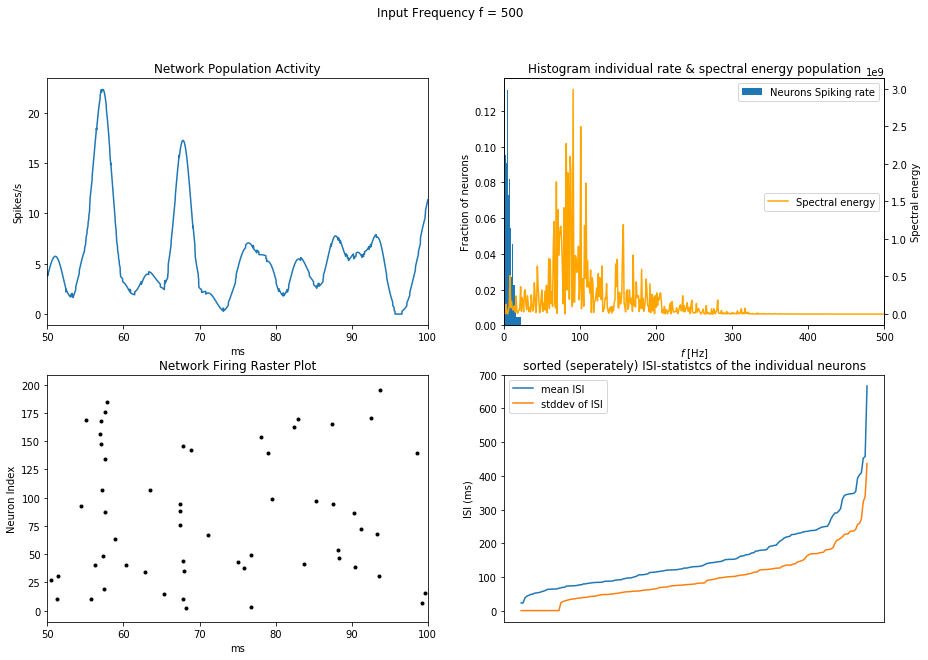

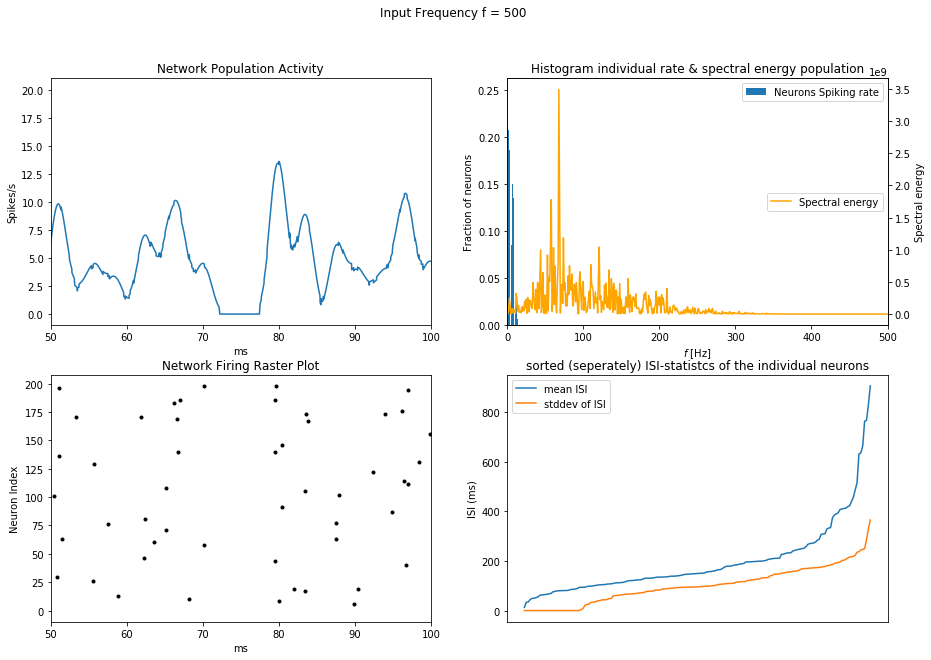

In [10]:
cv , Qs, f_peaks, f_means , input_freqs = master_run(500, Qs, f_peaks, f_means , input_freqs, None, initial = True)

-- Run: No GABA --


Before v = -65. mV
After v = -73.26112389 mV


-- Run: With GABA --


Before v = -65. mV
After v = -65.5808754 mV


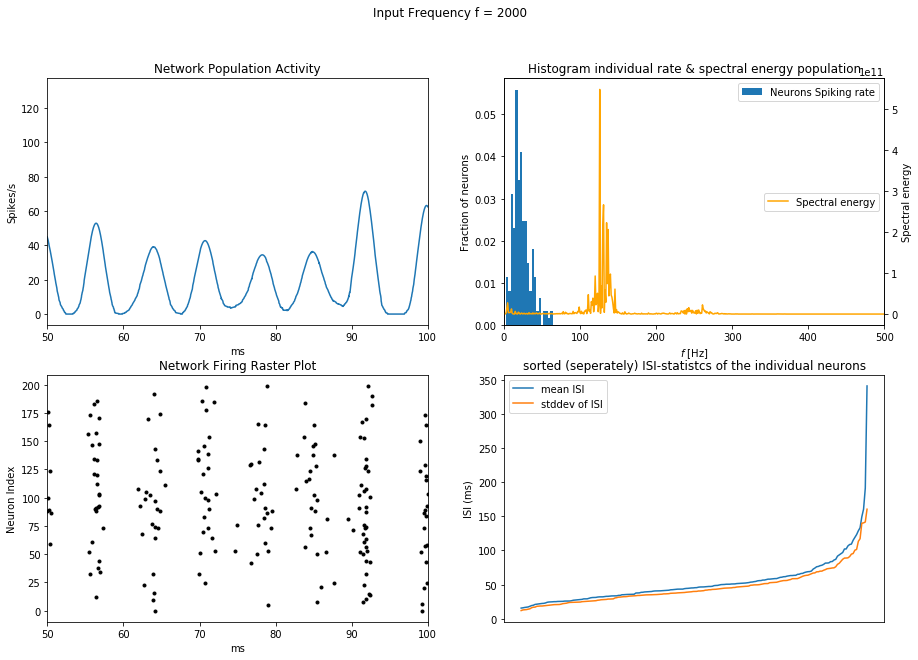

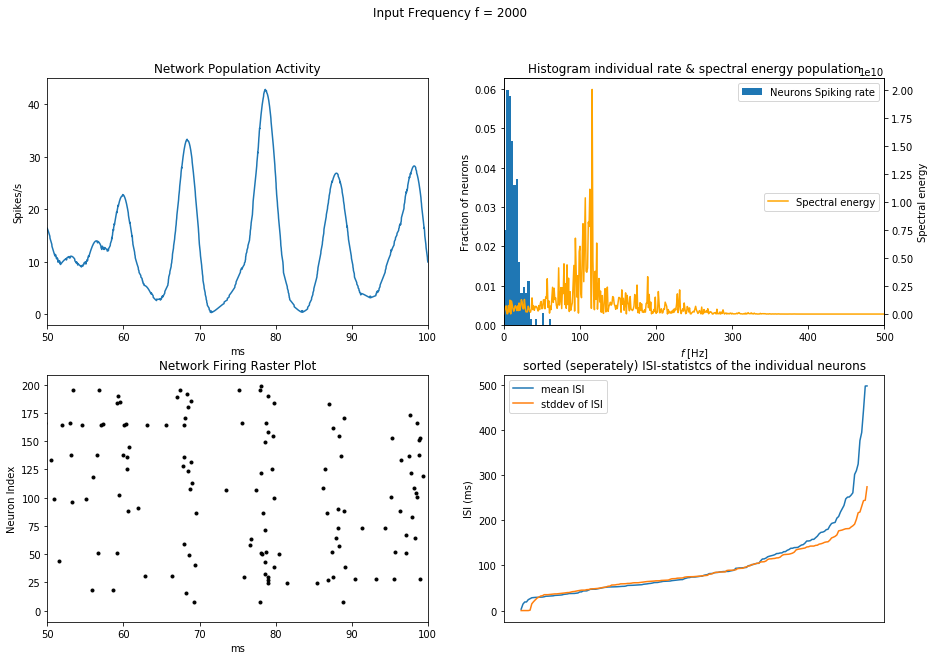

In [11]:
cv , Qs, f_peaks, f_means , input_freqs = master_run(2000, Qs, f_peaks, f_means , input_freqs, cv)

-- Run: No GABA --


Before v = -65. mV
After v = -69.06123741 mV


-- Run: With GABA --


Before v = -65. mV
After v = -67. mV


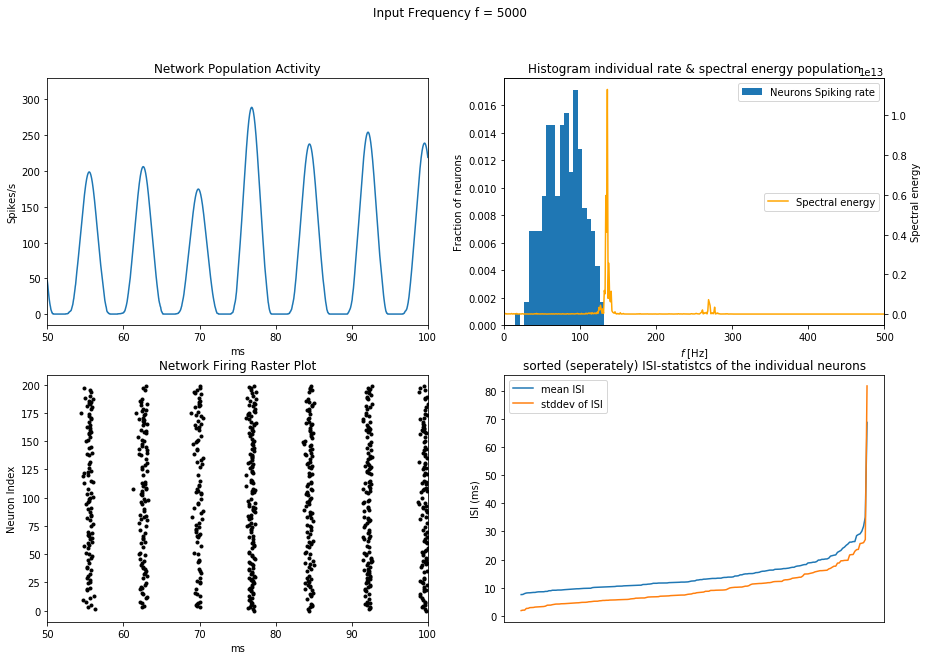

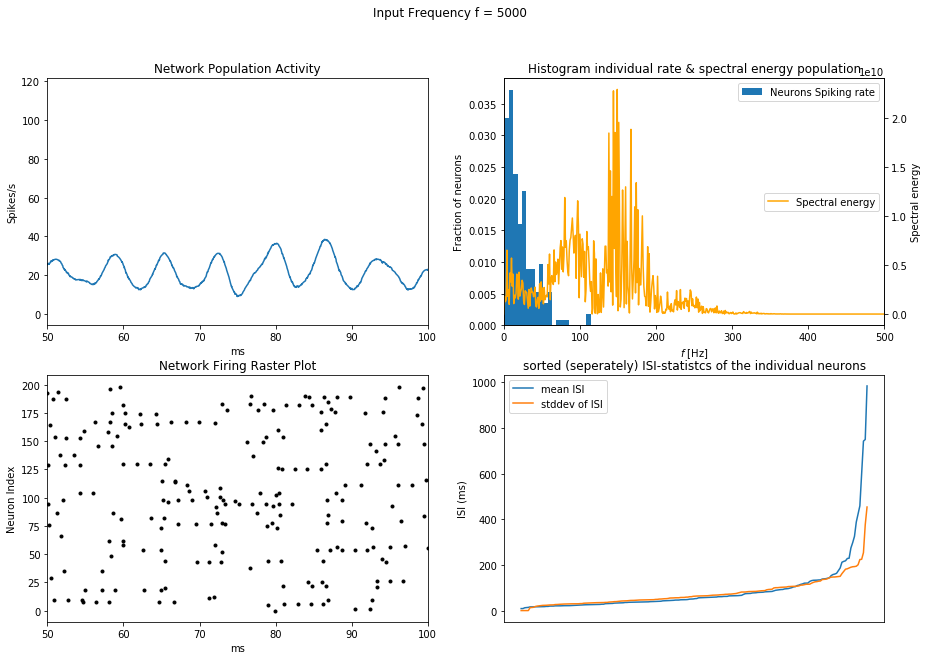

In [12]:
cv , Qs, f_peaks, f_means , input_freqs = master_run(5000, Qs, f_peaks, f_means , input_freqs, cv)

-- Run: No GABA --


Before v = -65. mV
After v = -72.63417539 mV


-- Run: With GABA --


Before v = -65. mV
After v = -68.97511937 mV


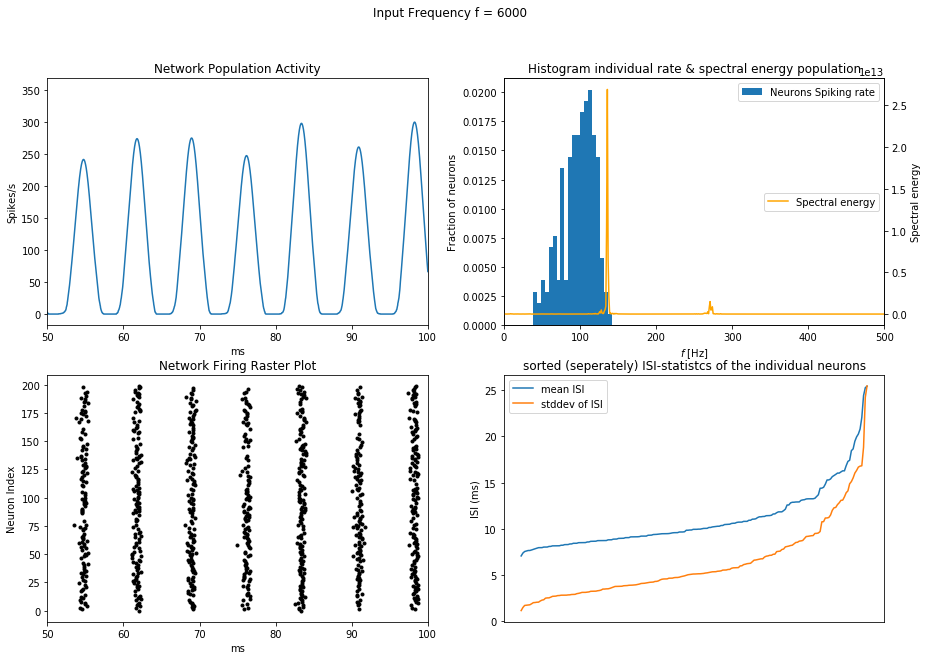

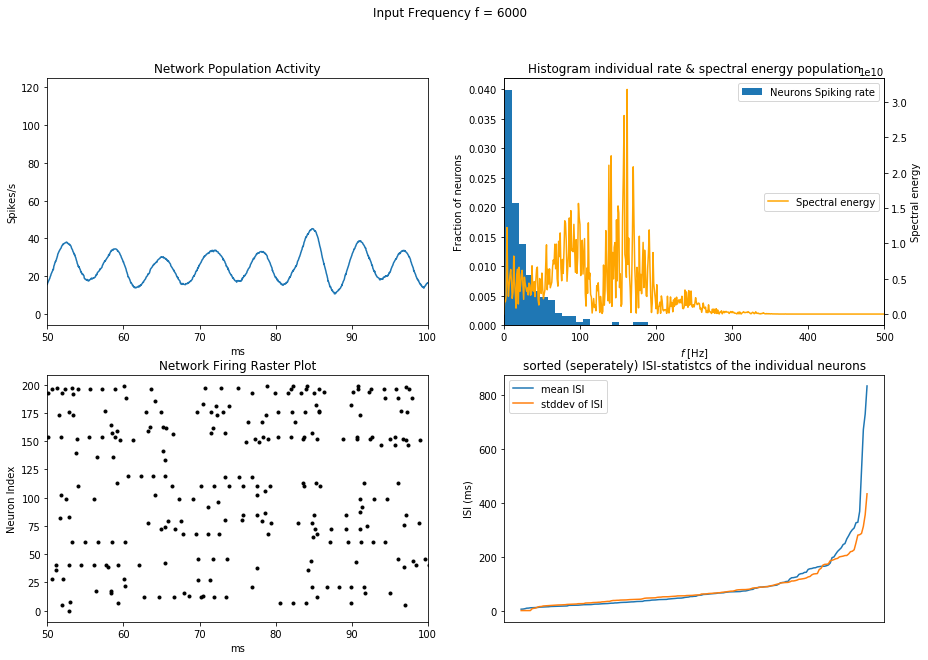

In [13]:
cv , Qs, f_peaks, f_means , input_freqs = master_run(6000, Qs, f_peaks, f_means , input_freqs, cv)

-- Run: No GABA --


Before v = -65. mV
After v = -67. mV


-- Run: With GABA --


Before v = -65. mV
After v = -67. mV


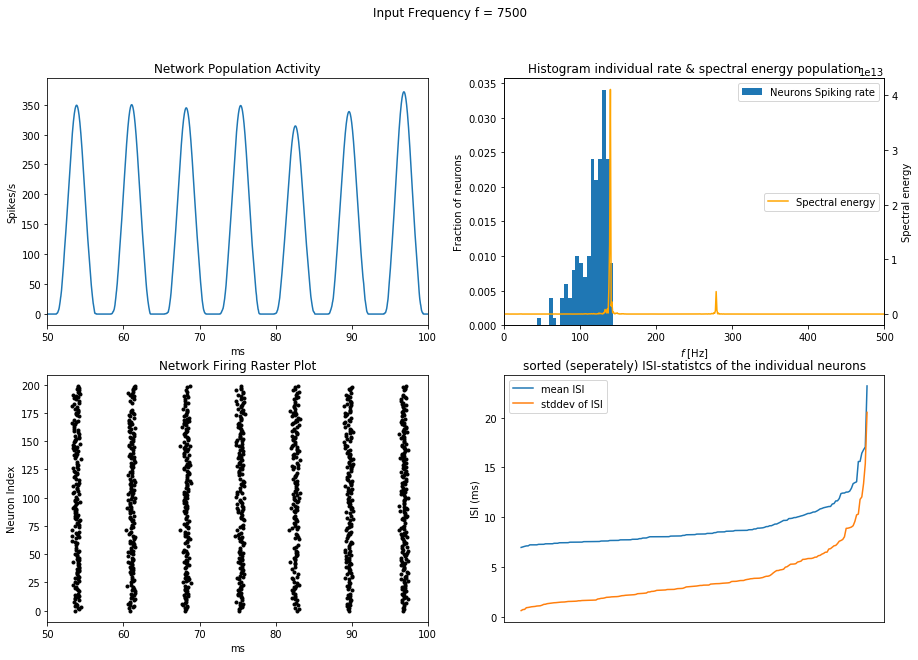

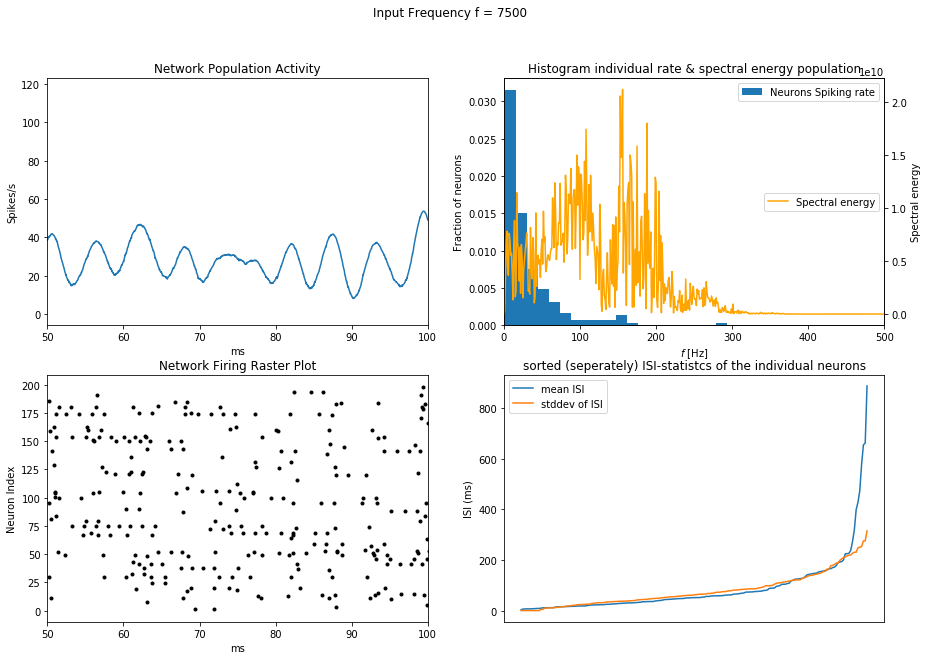

In [14]:
cv , Qs, f_peaks, f_means , input_freqs = master_run(7500, Qs, f_peaks, f_means , input_freqs, cv)

-- Run: No GABA --


Before v = -65. mV
After v = -56.7935234 mV


-- Run: With GABA --


Before v = -65. mV
After v = -64.71969422 mV


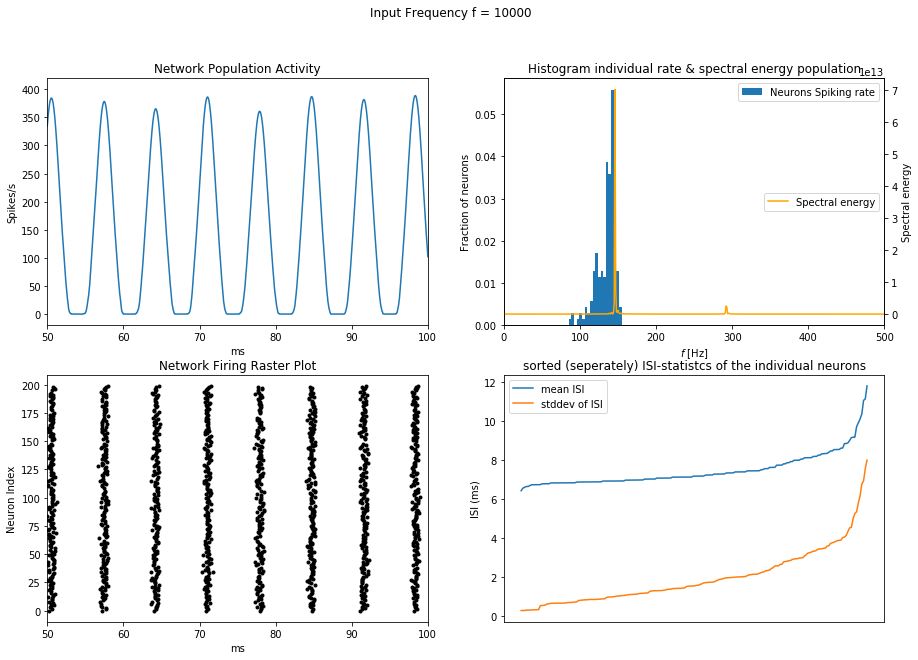

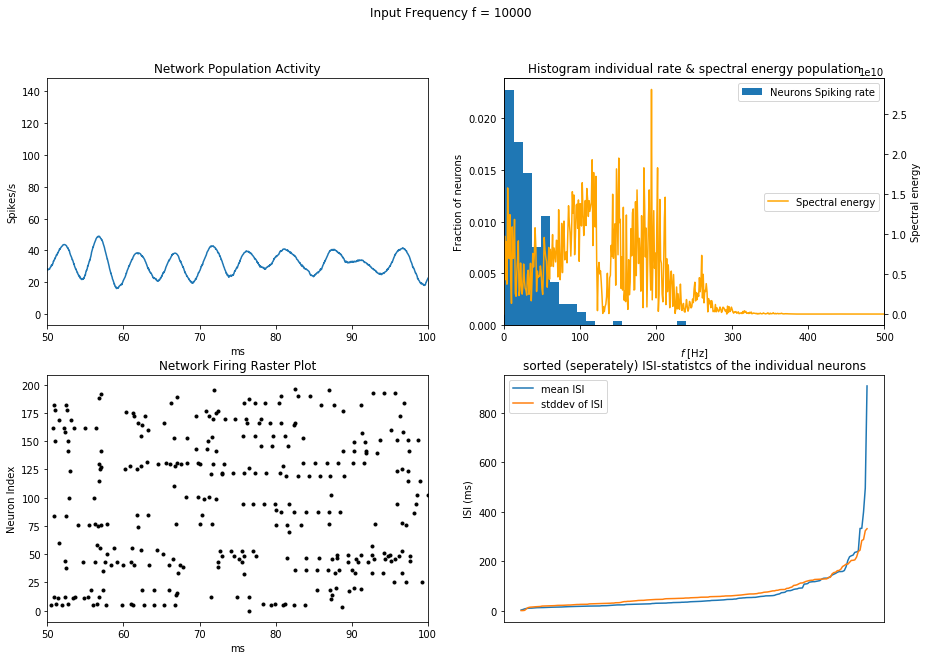

In [15]:
cv , Qs, f_peaks, f_means , input_freqs = master_run(10000, Qs, f_peaks, f_means , input_freqs, cv)

-- Run: No GABA --


Before v = -65. mV
After v = -53.03029066 mV


-- Run: With GABA --


Before v = -65. mV
After v = -64.46705542 mV


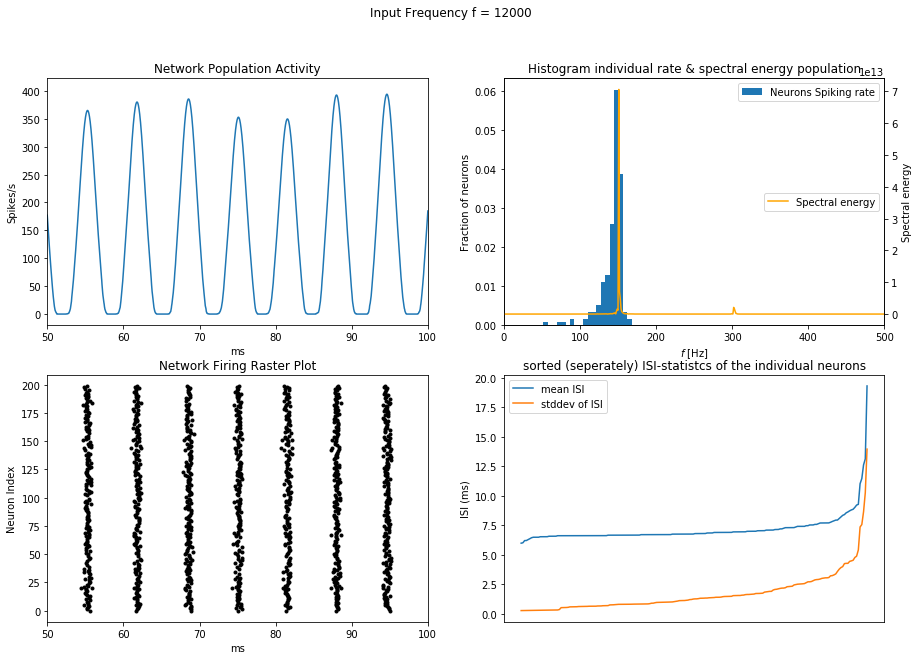

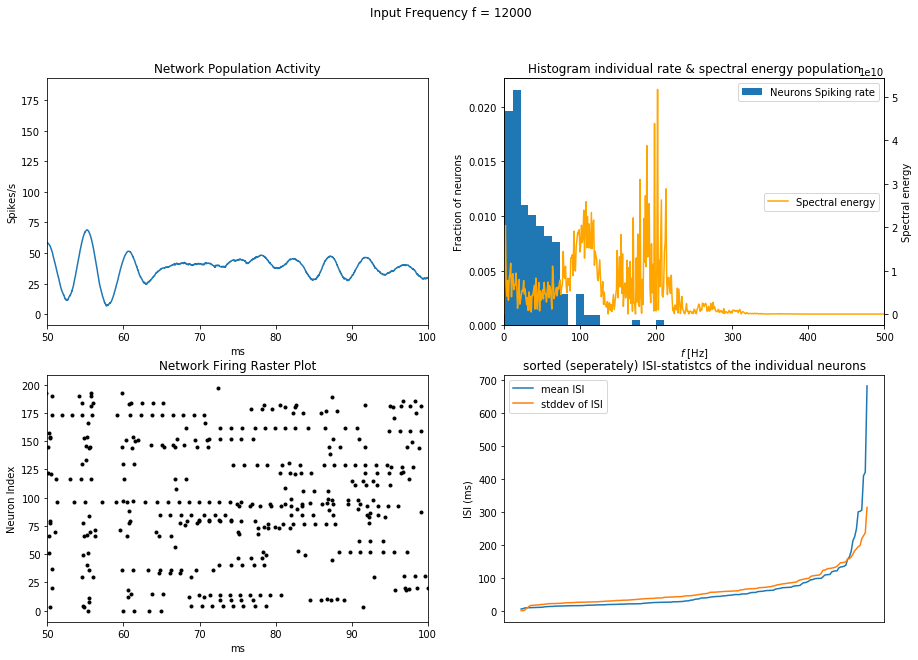

In [16]:
cv , Qs, f_peaks, f_means , input_freqs = master_run(12000, Qs, f_peaks, f_means , input_freqs, cv)

-- Run: No GABA --


Before v = -65. mV
After v = -67. mV


-- Run: With GABA --


Before v = -65. mV
After v = -68.63237756 mV


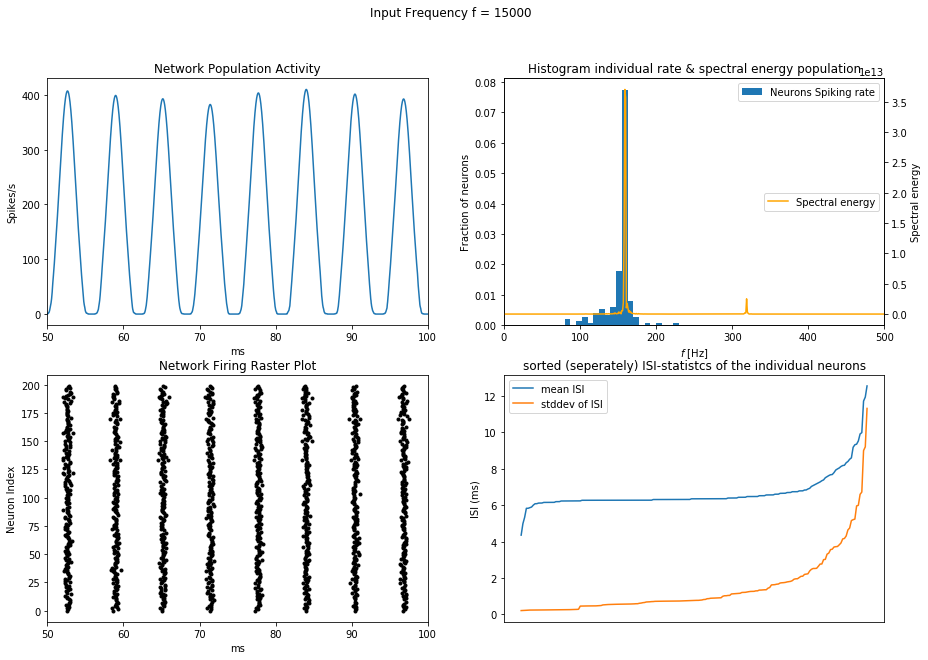

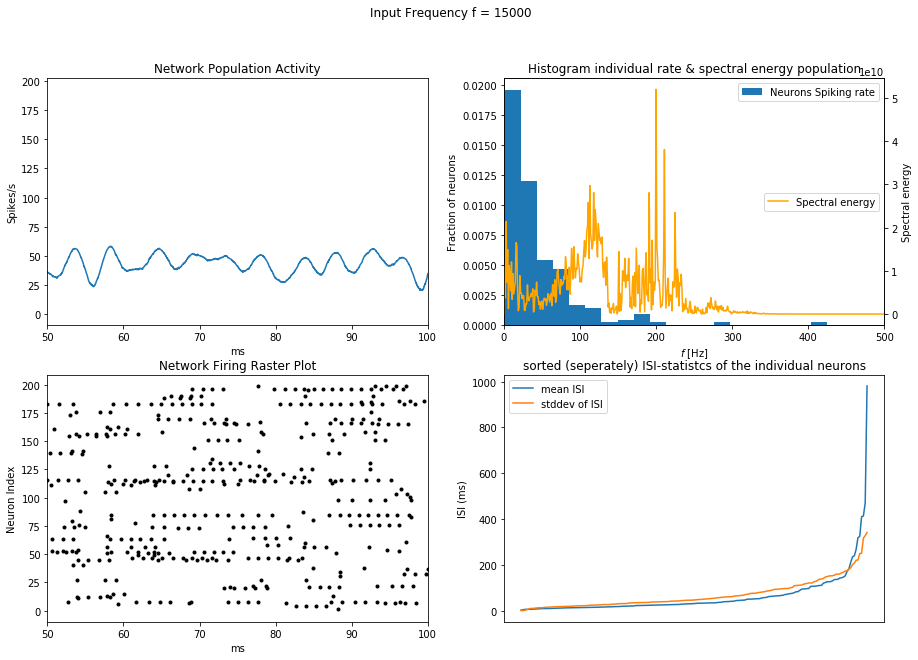

In [17]:
cv , Qs, f_peaks, f_means , input_freqs = master_run(15000, Qs, f_peaks, f_means , input_freqs, cv)

# Some remarks
  We actually observe that the 200 Hz oscillation peak does not shift in frequency (apart from when the input frequency is 15 kHz.) However, we note the significant decrease in the power of that frequency in the spectral energy distribution. (Isn't this the same kinda result from the paper??)

# Inter Spike Interval and Variability 

In [18]:
plt.rcParams['figure.figsize'] = (19,7)
#plt.errorbar(np.arange(len(isi_means)) , isi_means , yerr = isi_std, label = 'f = 10kHz')
plt.plot(np.sort(isi_means_10k), label = 'f = 10kHz')
plt.plot(np.sort(isi_means_G10k), label = 'Gaba')
plt.yscale('log')
#plt.xlabel('Neuron Index')
plt.ylabel('ISI (ms)')
plt.title('ISI Variability No GABA' )
plt.legend()
plt.show()

NameError: name 'isi_means_10k' is not defined

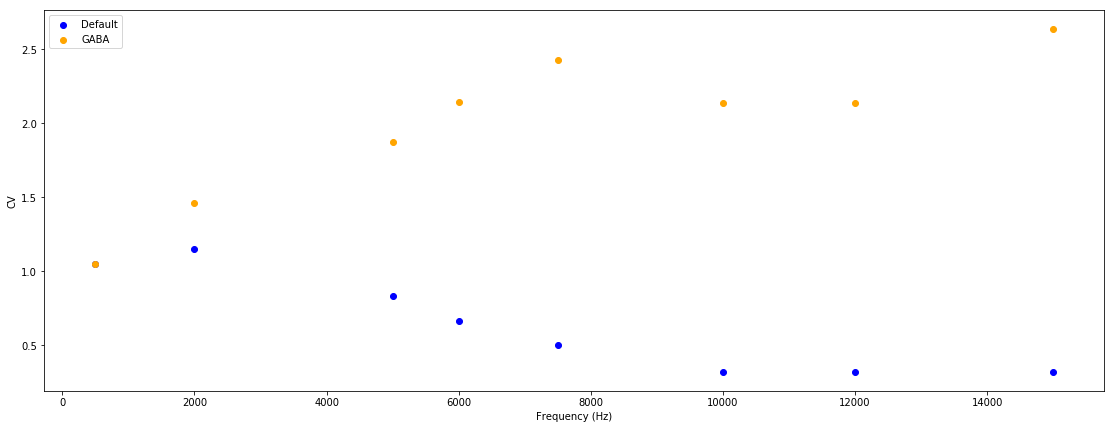

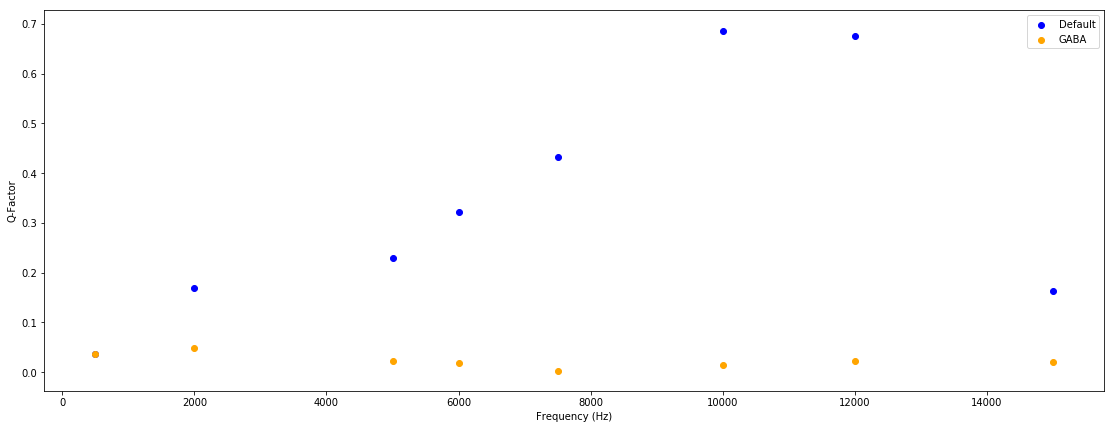

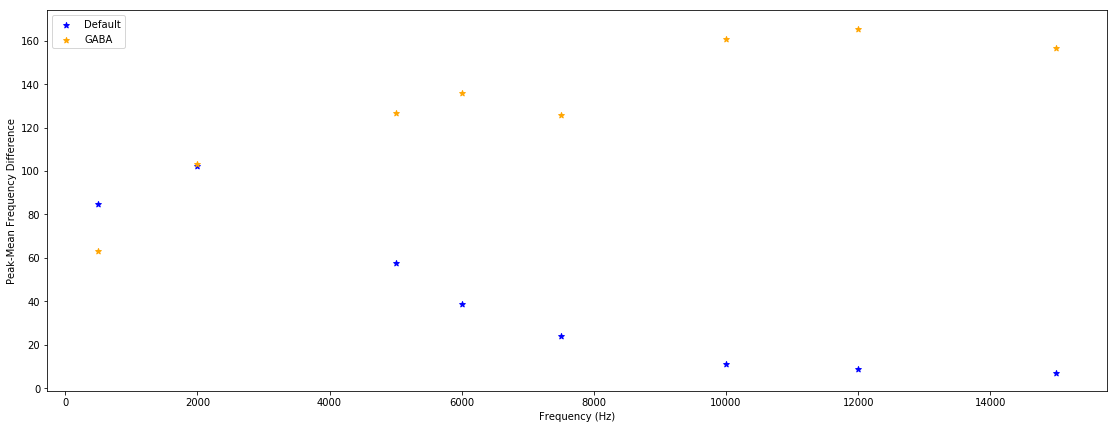

In [21]:
fig =plt.figure()
cv_gaba = cv[np.where(cv[:,2])].T
cv_def = cv[np.where(cv[:,2]==0)].T

plt.scatter(cv_def[:][1],cv_def[:][0],color='blue',label='Default')
plt.scatter(cv_gaba[:][1],cv_gaba[:][0],color='orange',label='GABA') 

plt.legend()
plt.xlabel('Frequency (Hz)');
plt.ylabel('CV');


# Q- Factor Plot 
fig =plt.figure()
plt.scatter(input_freqs[0] ,Qs[0] , color='blue',label='Default')
plt.scatter(input_freqs[0] ,Qs[1],color='orange',label='GABA')
plt.legend()
plt.xlabel('Frequency (Hz)');
plt.ylabel('Q-Factor');

# Mean Network Freq vs FFT Peak (Resonant) Frequency 
fig =plt.figure()
plt.scatter(input_freqs[0], np.array(f_peaks[0]) -np.array(f_means[0]),marker = '*',color='blue',label='Default')
plt.scatter(input_freqs[0], np.array(f_peaks[1]) - np.array(f_means[1]),marker = '*',color='orange',label='GABA')
plt.legend()
plt.xlabel('Frequency (Hz)');
plt.ylabel('Peak-Mean Frequency Difference');



# Some remarks
- From the ISI mean distribution, we definitely see a much more biologically and informationally relevant inter spike interval and also less variability in the ISIs. A mean ISI of ~ 5 ms could still imply tight coupling between neurons while ISIs on the order of 20 ms or so, with high standard deviation would more indicate random neuronal firings. This could be one of the metrics to characeterise the strength and type of the oscillation the network achieves. 